In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras

2024-10-17 12:41:14.958610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Table of contents

```
0. Introduction

1. Load the dataset | [In] 2 ~
   - noise 추가하기 | [In] 11 ~

2. Denosing-Autoencoder | [In] 16 ~
```

# 0. Introduction

**Dataset**  
- [DSA](https://github.com/MyungKyuYi/AI-class/blob/main/Pre-trained_model.ipynb)

**Environment**
- macOS `x86`cpu

**Framework**  
- TensorFlow: Version `2.10.0`

**Dependencies**  
- Python: Version `3.9.18`
- Numpy: Version `1.26.4`
- Pandas: Version `2.2.2`
- Matplotlib: Version `3.9.2`
- scikit-learn: Version `1.5.1`

**Purpose**
- Train / Test set을 나누고, 각각에 noise를 추가한다(전용 api 존재).
  + noise 넣는 것은 특정 컬럼에만 노이즈를 줘도 되고, 모든 컬럼에 노이즈를 줘도 됨.
  + 중요한 것은 노이즈를 준 컬럼이라면 해당 컬럼의 모든 로우에 대해서 노이즈가 적용되어야 한다는 것.
- input data를 noised-train으로, target을 원본 train으로 하여 학습한다.
  + model은 이 둘의 차이를 줄이기 위해 noise를 제거하는 방향으로 학습된다.
- noised-test를 model에 넣은 prediction값(= model에 의해서 noise가 제거된 데이터)과 원본 test(=noise가 하나도 없는 데이터)의 차이를 측정한다.
  + 이 차이가 일정 값(threshold) 이상이면 1(andingInElevatorStill)로 판단.

**References**
- \-

**Performance(accuracy)**  
- [이전 task: lying과 jumping의 구분]([Github-rudevico](https://github.com/HyoYoonNam/DL-Class/blob/main/assignment/week5_AutoEncoder_DSA.ipynb))
```
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       480

    accuracy                           1.00      1440
   macro avg       1.00      1.00      1.00      1440
weighted avg       1.00      1.00      1.00      1440
```

- [이전 task: lying과 standingInElevatorStill의 구분 - Linear AE]([Github-rudevico](https://github.com/HyoYoonNam/DL-Class/blob/main/assignment/week7_Linear-Autoencoder_DSA.ipynb))
```
[threshold = 4.8]
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       960
           1       0.53      1.00      0.70       480

    accuracy                           0.71      1440
   macro avg       0.77      0.78      0.71      1440
weighted avg       0.84      0.71      0.71      1440
```

- [이전 task: lying과 standingInElevatorStill의 구분 - Nonlinear AE]
```
일반적인 linear autoencoder와 denosing만 추가한 경우의 autoencoder를 비교하는 것이 목적이므로,
해당 task에 대한 classification report는 생략.
```

- [현재 task: lying과 standingInElevatorStill의 구분 - Denosing AE](-)
```
[threshold = 4.8]
              precision    recall  f1-score   support

           0       0.96      0.62      0.75       960
           1       0.55      0.95      0.70       480

    accuracy                           0.73      1440
   macro avg       0.76      0.78      0.73      1440
weighted avg       0.82      0.73      0.73      1440
```

# 1. Load the dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv('./datasets/DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [4]:
np.unique(df['activity'])

# 여기서 'lyingBack', 'lyingRigh', 'standingInElevatorStill'을 사용한다.

array(['ascendingStairs', 'basketBall', 'crossTrainer',
       'cyclingHorizontal', 'cyclingVertical', 'decendingStairs',
       'jumping', 'lyingBack', 'lyingRigh', 'movingInElevator', 'rowing',
       'runningTreadmill', 'sitting', 'standing',
       'standingInElevatorStill', 'stepper', 'walkingLot',
       'walkingTreadmillFlat', 'walkingTreadmillIncline'], dtype=object)

In [5]:
# lying만 있는 train set
df_train = df[(df['activity'] == 'lyingBack') | (df['activity'] == 'lyingRigh')]
print(f'df_train.shape: {df_train.shape} \ndf_train.unique: {np.unique(df_train["activity"])}')
df_train

df_train.shape: (960, 272) 
df_train.unique: ['lyingBack' 'lyingRigh']


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2.620502,2.6592,2.5891,0.000199,0.014113,0.148452,-9.392025,-9.34240,-9.42070,0.000242,...,0.009589,0.401254,-0.410987,-0.38221,-0.44605,9.935077e-05,0.009967,-0.597598,lyingRigh,p8
1916,2.613423,2.6572,2.5815,0.000207,0.014387,0.368746,-9.398851,-9.36570,-9.43560,0.000156,...,0.008588,0.147180,-0.411248,-0.36581,-0.43676,8.659481e-05,0.009306,1.021454,lyingRigh,p8
1917,2.614750,2.6576,2.5654,0.000257,0.016018,-0.007991,-9.397350,-9.36280,-9.43130,0.000214,...,0.005814,0.032341,-0.409787,-0.37926,-0.43431,7.258946e-05,0.008520,0.431012,lyingRigh,p8
1918,2.620167,2.6589,2.5781,0.000216,0.014691,-0.114904,-9.397014,-9.36490,-9.45390,0.000257,...,0.009510,0.409508,-0.409101,-0.36074,-0.44087,1.127801e-04,0.010620,1.368666,lyingRigh,p8


In [6]:
# 정상 샘플만 있는 X_train
# lyingBack과 lyingRigh를 모두 0(Normal)로 변경
df_train.loc[:, 'activity'] = 0

In [7]:
# X인 동시에 y. self supervised learning
X_train = df_train.drop(['activity', 'people'], axis=1)
print(f'X_train.shape: {X_train.shape}')

X_train.shape: (960, 270)


In [8]:
# lying과 standing 모두 있는 X_test
df_test = df[(df['activity'] == 'lyingBack') | (df['activity'] == 'lyingRigh') | (df['activity'] == 'standingInElevatorStill')]
print(f'df_test.shape: {df_test.shape} \ndf_test.unique: {np.unique(df_test["activity"])}')
df_test

df_test.shape: (1440, 272) 
df_test.unique: ['lyingBack' 'lyingRigh' 'standingInElevatorStill']


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.417440,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.403720,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.426160,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.308770,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.389000,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9.802530,9.8423,9.6857,0.000865,0.029403,-1.341638,-0.185503,-0.090833,-0.25891,0.001316,...,0.006399,-0.962316,0.488304,0.51448,0.46222,5.126574e-05,0.007160,-0.717994,standingInElevatorStill,p8
3356,9.799047,9.9038,9.7250,0.000750,0.027379,0.468885,-0.200147,-0.113400,-0.29976,0.001781,...,0.006276,-0.513505,0.488314,0.51509,0.46554,4.488257e-05,0.006699,0.136985,standingInElevatorStill,p8
3357,9.797938,9.8537,9.7347,0.000576,0.023998,-0.365021,-0.195523,-0.132300,-0.25615,0.001006,...,0.005879,0.691562,0.486659,0.51104,0.46926,4.251657e-05,0.006520,0.178792,standingInElevatorStill,p8
3358,9.606040,9.9302,9.1379,0.067806,0.260396,-0.719145,-0.188162,-0.119480,-0.25154,0.000760,...,0.007984,-0.736630,0.490615,0.53319,0.46602,8.602620e-05,0.009275,1.175198,standingInElevatorStill,p8


In [9]:
# 정상 sample과 비정상 sample이 모두 있는 X_test
# lyingBack과 lyingRigh를 모두 0(Normal)로 변경
# sitting은 1(Abnormal)로 변경
df_test.loc[df_test['activity'].isin(['lyingBack', 'lyingRigh']), 'activity'] = 0
df_test.loc[df_test['activity'] == 'standingInElevatorStill', 'activity'] = 1

# 기존에 y_test는 string value가 있었기 때문에 dtype이 object임
# 이를 위에서 숫자로 바꿔줬어도 object dtype에 숫자를 담을 수 있기에 여전히 object dtype으로 유지
# 이후 연산을 위해서 dtype을 int로 변경
df_test['activity'] = df_test['activity'].astype(int)

/var/folders/m_/5z28qmvj575cs_9xldf0gyd80000gn/T/ipykernel_87980/611979991.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['activity'] = df_test['activity'].astype(int)


In [10]:
# test set의 경우 accuracy 평가를 위해서 기존 y를 남겨둠
X_test = df_test.drop(['activity', 'people'], axis=1)
y_test = df_test['activity'].to_numpy()

# # string -> int로 바꾸는 LabelEncoder 사용
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# y_test_labeled = label_encoder.fit_transform(y_test)

# print(f'X_test.shape: {X_test.shape}')
# print(f'Before LabelEncode: {np.unique(df_test["activity"])}')
# print(f'After LabelEncode: {np.unique(y_test_labeled)} \n')
# print(f'y_test_labeled.head() \n{y_test_labeled[:5]}')

## noise 추가하기

In [11]:
print(type(X_train))
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [12]:
X_train

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.56276,9.725263e-07,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,0.56394,6.211659e-07,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,0.56445,4.579046e-07,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,0.56420,4.703523e-07,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.56455,5.467316e-07,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2.620502,2.6592,2.5891,0.000199,0.014113,0.148452,-9.392025,-9.34240,-9.42070,0.000242,...,-0.54522,9.195642e-05,0.009589,0.401254,-0.410987,-0.38221,-0.44605,9.935077e-05,0.009967,-0.597598
1916,2.613423,2.6572,2.5815,0.000207,0.014387,0.368746,-9.398851,-9.36570,-9.43560,0.000156,...,-0.55652,7.375030e-05,0.008588,0.147180,-0.411248,-0.36581,-0.43676,8.659481e-05,0.009306,1.021454
1917,2.614750,2.6576,2.5654,0.000257,0.016018,-0.007991,-9.397350,-9.36280,-9.43130,0.000214,...,-0.53640,3.380089e-05,0.005814,0.032341,-0.409787,-0.37926,-0.43431,7.258946e-05,0.008520,0.431012
1918,2.620167,2.6589,2.5781,0.000216,0.014691,-0.114904,-9.397014,-9.36490,-9.45390,0.000257,...,-0.54565,9.044032e-05,0.009510,0.409508,-0.409101,-0.36074,-0.44087,1.127801e-04,0.010620,1.368666


In [13]:
# 모든 column에 noise를 추가.
# ㄴ 특정 column(ex. 중요도 높은 column)에만 noise를 추가해도 됨.
noise_df_train = X_train.copy()
noise_factor = 0.5
noise_df_train = noise_df_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=noise_df_train.shape)

noise_df_train

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
960,-5.607905,-5.456408,-4.898696,0.280092,0.708092,1.457426,-0.435626,-0.841247,-1.307622,-0.471486,...,0.966378,-0.283791,0.853836,0.100461,-0.161641,-0.559960,-1.282781,-0.436804,0.018729,-0.759365
961,-4.046661,-5.239213,-4.801935,-0.810968,-0.467260,2.060367,-0.989856,-0.528871,-0.822445,0.025031,...,-0.164112,-0.859485,0.072670,-0.204110,-0.741532,-0.304800,-1.078583,-0.085019,0.004213,0.175951
962,-5.040137,-4.659138,-5.155919,-0.007766,-0.690780,1.475287,-1.785808,-0.824588,-0.300986,0.029315,...,0.311657,-0.270853,-0.247393,-0.372618,-0.782687,-0.663280,-0.318003,-0.682458,0.127415,0.503931
963,-3.829573,-4.478333,-4.752391,0.345615,-0.151244,0.367373,-0.542380,-0.749537,-0.105476,-0.080652,...,0.808750,0.443024,0.383388,-0.189193,-0.383425,-0.499391,-0.262984,-0.267271,-0.096036,-0.869130
964,-5.139199,-4.448823,-4.558481,0.578535,0.086841,1.893589,-0.397141,-0.344565,0.539507,-0.519869,...,-0.224111,0.622524,-0.262135,0.430168,-0.297391,-0.789440,-0.349566,-0.182540,-0.452408,0.053923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,2.310611,2.468482,3.552412,0.228403,0.398685,-0.299487,-9.771697,-9.502245,-8.956176,0.691780,...,0.639622,0.144444,0.464669,-0.004994,-0.686875,-0.101581,-0.594717,-0.269254,-0.448729,-0.557749
1916,2.587796,2.722073,3.188061,-0.492819,0.483835,0.571844,-10.458499,-8.850167,-9.743269,0.357829,...,0.553182,0.693780,-1.066049,0.747280,0.190064,-0.908731,0.003975,0.413496,-0.237287,0.981771
1917,2.285546,1.488429,2.826096,0.350215,-0.585895,-0.112130,-9.596200,-9.404162,-9.727997,-0.177877,...,-0.822670,0.235546,-0.222165,1.074025,-0.255059,0.330784,-0.220033,-0.020714,0.549957,0.192424
1918,2.467794,2.849489,2.252482,0.322335,0.654987,-0.197112,-9.759379,-9.929130,-9.773362,-0.425012,...,-0.408837,-0.740542,-0.454030,0.859858,-0.654967,0.008144,-1.193823,-0.169511,0.938147,1.635670


In [14]:
# 모든 column에 noise를 추가.
# ㄴ 특정 column(ex. 중요도 높은 column)에만 noise를 추가해도 됨.
noise_df_test = X_test.copy()
noise_factor = 0.5
noise_df_test = noise_df_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=noise_df_test.shape)

noise_df_test

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
960,-4.283731,-5.240824,-4.549601,-0.236751,0.659707,1.192127,-0.953818,-0.375179,-0.235708,-0.429431,...,1.010183,-0.242841,-0.511672,-0.689757,-1.035984,-0.069409,-0.533352,0.012997,0.074539,-0.094932
961,-4.779559,-4.678499,-4.641237,0.701647,0.790234,0.888776,-0.299396,-0.095405,-0.979625,-0.045289,...,0.385952,-0.094988,-0.276791,0.050884,-0.904526,-0.717206,-0.344761,-0.159824,0.177941,0.358263
962,-4.834959,-4.377558,-4.628384,0.531452,0.063191,1.593319,-1.400222,-0.180422,0.299981,-0.718590,...,0.980320,-0.001572,0.227722,-0.349981,-0.852808,-0.847019,-0.903780,-0.234697,-0.652987,0.677538
963,-4.943841,-4.504053,-5.224554,0.039490,-0.147068,1.322324,-0.364495,-0.026866,0.271802,0.339100,...,0.378930,-0.275606,-0.094659,-0.709127,0.153200,-0.999159,0.068408,0.225802,-0.455502,-0.329091
964,-4.540393,-4.917738,-4.616164,0.388703,-0.436421,0.284225,0.105128,-0.162470,-0.248165,-0.015908,...,0.669668,-0.739107,-0.945864,-0.311443,-0.833926,-0.437846,-0.204345,-0.247596,-0.565224,0.027617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9.566202,9.358992,9.430374,0.004288,-0.621878,-0.801014,-0.584254,-1.309900,-0.718762,-0.109259,...,0.304117,0.319564,-0.841083,-1.678567,0.708295,0.537990,0.942436,0.294858,0.139494,0.232945
3356,9.967474,9.667884,9.533363,0.319440,1.059944,-0.207197,-0.541403,-1.113102,0.405957,-0.137557,...,0.344002,0.435747,0.074339,0.035825,-0.028201,0.895259,0.258550,-0.661129,-0.385518,-0.385265
3357,10.867358,10.973492,10.237550,-0.324763,-0.013816,-0.468564,-0.832048,-0.280249,-0.852381,-0.230031,...,0.619286,-0.368202,0.733708,0.799510,0.412219,-0.042055,-0.111770,-0.428357,-0.375482,0.379338
3358,9.584262,9.648044,9.347167,0.241368,-0.448333,-1.178415,0.397037,-0.376137,-0.415322,0.401649,...,0.504897,-1.083230,0.374118,-0.009871,0.263424,1.255874,0.050159,0.471278,0.070024,0.477293


In [15]:
# noise된 훈련 데이터
X_train_noise = noise_df_train.to_numpy()

# 훈련에 대한 target
X_train = X_train.to_numpy()

# noise된 테스트 데이터
X_test_noise = noise_df_test.to_numpy()

# 2. Denosing-Autoencoder

In [16]:
import tensorflow as tf
import tensorflow.keras as keras

In [17]:
input_dim = X_train_noise.shape[1]
encoding_dim = int(input_dim / 2)
bottleneck_dim = int(encoding_dim / 2)

num_epochs = 50
batch_size = 32

In [18]:
autoencoder = keras.Sequential(name='autoencoder')
# encoder
# 이때 input은 noise가 추가된 데이터
autoencoder.add(keras.layers.Input(shape=(input_dim,)))
autoencoder.add(keras.layers.Dense(encoding_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(bottleneck_dim, activation='relu'))
# decoder
autoencoder.add(keras.layers.Dense(bottleneck_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(encoding_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

# encoder와 decoder가 대칭적으로 node 수가 동일한 Linear-Autoencoder

2024-10-17 12:41:18.163492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 135)               36585     
                                                                 
 dense_1 (Dense)             (None, 67)                9112      
                                                                 
 dense_2 (Dense)             (None, 67)                4556      
                                                                 
 dense_3 (Dense)             (None, 135)               9180      
                                                                 
 dense_4 (Dense)             (None, 270)               36720     
                                                                 
Total params: 96,153
Trainable params: 96,153
Non-trainable params: 0
_________________________________________________________________


In [19]:
autoencoder.compile(optimizer='adam',
                    loss='mse')

교수님이 설명한 방식이 이해가 가지 않아서 다시 질문 필요함.
```python
# 교수님이 설명한 방식
autoencoder.fit(X_train_noise, X_train_noise, 
                validation_data=(X_train, X_train)
               )
```

```python
# 내가 옳다고 생각하는 방식
autoencoder.fit(X_train_noise, X_train, 
                validation_data=(X_train_noise, X_train)
               )
```

**내 방식에 대한 근거 자료**  
1. tensorflow 공식 `Model.fit()` method의 `validation_set` parameter에 대한 설명. [Link](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)  
-> Data on which to evaluate the loss and any model metrics at the end of each epoch. **The model will not be trained on this data**.

2. tensorflow 공식 denosing-autoencoder 예제 코드. [Link](https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko#%EB%91%90_%EB%B2%88%EC%A7%B8_%EC%98%88_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%85%B8%EC%9D%B4%EC%A6%88_%EC%A0%9C%EA%B1%B0)  
```python
# tensorflow 공식 예제 코드
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
```

3. [DENOSING IMAGES WITH AUTOENCODERS | by Serkan Emre Elçi | Medium](https://medium.com/@serkanemreelci/denosing-images-with-autoencoders-1b2833441338)
```python
# 기타 예제 코드
autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                validation_data=[X_test_noise, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)
```

4. [캐글(Kaggle) 예제 - 케라스(Keras.. : 네이버블로그](https://blog.naver.com/ckdgus1433/221443838135)
```python
# 기타 예제 코드
hist = model.fit(X, X_target, epochs=epochs, batch_size=batch_size)

# 특이한 점은, X와, X_target이 동시에 model.fit 함수의 입력으로 들어가게 된다는 것이다.
# X는 노이즈가 섞인 문서, 즉 앞서 불러왔던 train에 해당하며 오토 인코더의 입력 층을 구성하고,
# X_target은 노이즈가 없는 문서, 즉 train_cleaned에 해당하며 오토 인코더의 출력 층을 구성하게 된다.
```

In [20]:
# noise가 추가된 데이터를 X로,
# noise가 없는 원본 데이터를 y로 사용.
# 따라서 이 둘의 reconstruction error를 줄이도록 학습하게 됨.
# 즉 noise를 없애는 것을 학습하게 됨.

### 내가 주장한 방식
history = autoencoder.fit(X_train_noise, X_train, 
                          validation_data=(X_test_noise, X_test),
                          epochs=num_epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          verbose=2)


### 교수님이 주장한 방식
# history = autoencoder.fit(X_train_noise, X_train_noise, 
#                           validation_data=(X_train, X_train),
#                           epochs=num_epochs,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           verbose=2)

Epoch 1/50
30/30 - 1s - loss: 5.1732 - val_loss: 5.0273 - 526ms/epoch - 18ms/step
Epoch 2/50
30/30 - 0s - loss: 4.8872 - val_loss: 5.0188 - 88ms/epoch - 3ms/step
Epoch 3/50
30/30 - 0s - loss: 4.8700 - val_loss: 4.9974 - 100ms/epoch - 3ms/step
Epoch 4/50
30/30 - 0s - loss: 4.8634 - val_loss: 4.9765 - 94ms/epoch - 3ms/step
Epoch 5/50
30/30 - 0s - loss: 4.8608 - val_loss: 4.9662 - 97ms/epoch - 3ms/step
Epoch 6/50
30/30 - 0s - loss: 4.8594 - val_loss: 4.9612 - 89ms/epoch - 3ms/step
Epoch 7/50
30/30 - 0s - loss: 4.8586 - val_loss: 4.9574 - 103ms/epoch - 3ms/step
Epoch 8/50
30/30 - 0s - loss: 4.8582 - val_loss: 4.9569 - 99ms/epoch - 3ms/step
Epoch 9/50
30/30 - 0s - loss: 4.8579 - val_loss: 4.9560 - 90ms/epoch - 3ms/step
Epoch 10/50
30/30 - 0s - loss: 4.8576 - val_loss: 4.9581 - 106ms/epoch - 4ms/step
Epoch 11/50
30/30 - 0s - loss: 4.8572 - val_loss: 4.9562 - 99ms/epoch - 3ms/step
Epoch 12/50
30/30 - 0s - loss: 4.8525 - val_loss: 4.9497 - 92ms/epoch - 3ms/step
Epoch 13/50
30/30 - 0s - loss: 4

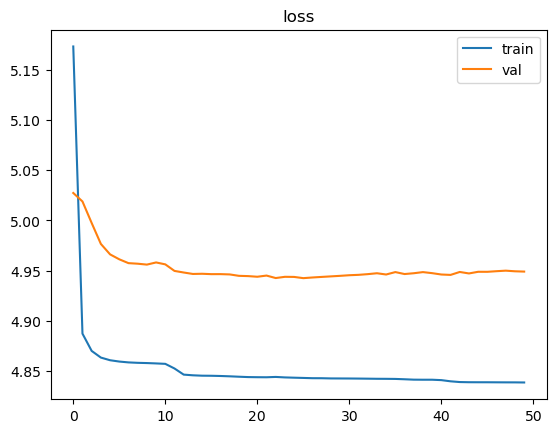

In [21]:
# epoch에 따른 loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label = 'train')
plt.plot(val_loss, label = 'val')
plt.title('loss')
plt.legend() # 우측 상단에 그래프 정보 띄워주는 거
plt.show()

In [22]:
# X_test에 대한 reconstruced data
predictions = autoencoder.predict(X_test_noise) 
# original data와 reconstruced data의 MSE 즉, reconstruction error
# ㄴ noise가 없던 X_test와 noise가 있었는데, model로 제거한 predictions의 차이를 의미.
# ㄴ 즉 noise를 얼마나 잘 제거했느냐를 의미.
mse = np.mean(np.power(X_test - predictions, 2), axis=1) 
                                                                                   
# reconstruction error에 따른 Fraud 여부를 저장할 dataframe 생성
error_df = pd.DataFrame({'Reconstruction_error': mse, # reconstruction error와
                        'True_class': y_test})        # 그때의 standingInElevatorStill 여부

error_df

45/45 [==============================] - 0s 855us/step


,Reconstruction_error,True_class
960,4.655293,0
961,4.647636,0
962,4.643174,0
963,4.665400,0
964,4.653277,0
...,...,...
3355,5.173461,1
3356,5.156212,1
3357,5.138865,1
3358,4.915002,1


In [23]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프를 보고 결정
# 일단 reconstruction error가 설정된 값을 넘으면 Sitting로 분류하도록 설정
threshold = 4.8

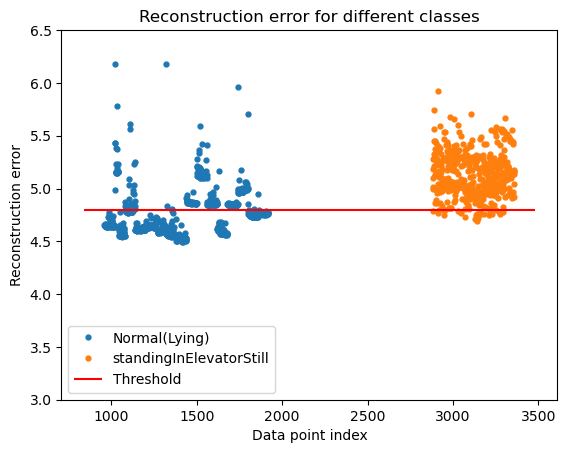

In [24]:
# y값 필터링
# error_df_test = error_df_test.reset_index()

groups = error_df.groupby('True_class')  # True_class별로 그룹화

fig, ax = plt.subplots()

# 각 클래스 그룹에 대해 점들을 플로팅
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="standingInElevatorStill" if name == 1 else "Normal(Lying)")

# 고정된 임계값을 빨간 선으로 표시
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Y축 범위를 설정
ax.set_ylim(3, 6.5)

# 범례, 제목, 축 레이블 설정
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

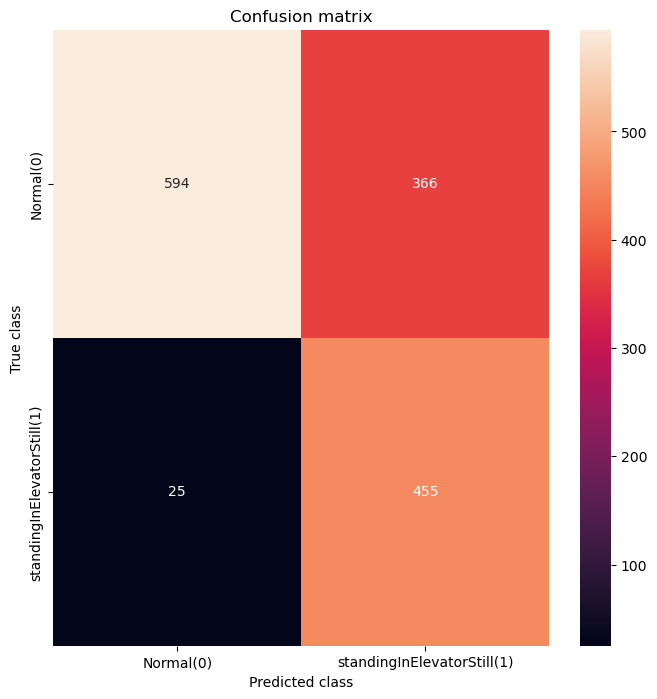

              precision    recall  f1-score   support

           0       0.96      0.62      0.75       960
           1       0.55      0.95      0.70       480

    accuracy                           0.73      1440
   macro avg       0.76      0.78      0.73      1440
weighted avg       0.82      0.73      0.73      1440



In [25]:
from sklearn.metrics import confusion_matrix, classification_report

LABELS = ['Normal(0)', 'standingInElevatorStill(1)']
y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(np.array(error_df.True_class), np.array(y_pred)))